In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from scipy.stats import ttest_ind
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn import feature_selection as fs
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.decomposition import PCA

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import  catboost
from catboost import * 
from catboost import CatBoostClassifier, Pool, cv
from catboost import MetricVisualizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgbm
from sklearn.ensemble import GradientBoostingClassifier as Gboost
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, f1_score, roc_curve
from sklearn.metrics import make_scorer, confusion_matrix, classification_report

## Sections ##

1. Problem definition


2. Loading data


3. Understanding the data


4. Distribution of variables

   4.1 Target
   
   4.2 Features
   
   4.2.1 Imputing
    

5. Data Preparation

    5.1.  Feature transformation
    
    5.2.  Feature Selection
    
    5.2.1. Performance with Full Set of Features
    
    5.3.  Balanced and split data
    
    5.4.  Recursive Feature Elimination with RFECV
    
    5.5.  Clusters and searching for outliers with DBSCAN
    

6. Algorithm Evaluation

    6.1. CatBoost 

    6.2. Logistic Regression

    6.3  SVC support vector classifier 
    

7. ROC AUC metric for KNeighborsClassifier, Decision Tree, RandomForestClassifier, GBoost, LinearDiscriminantAnalysis, LGBMClassifier, AdaboostClassifier models with default settings


8. Result Presentation


9. Resources







  # 1. Problem definition #

One of the key tasks of the bank is to be able to determine to whom it can extend credit and to whom it cannot. Historically, it has been proven that a large part of the bank's profit is formed precisely from the service of providing credits. Every single bank follows the Basel Committee on Banking Supervision regulations. In case of delay or non-return of credit, it is obliged to freeze part of its assets, thereby depriving itself of the opportunity to invest them and receive a profit.

 Banks as a conservative institution adhere to models that are interpretable, I will use a large number of models that are black boxes, but can be used as auxiliary for the bank to make the right decision, on such an important issue as credit scoring. FICO scores are the best known and most widely used consumer credit scores but I will use f1 score measure combining both precision and recall metrics, considering that banks do not want to lose money on loans that cannot be paid back, but also lose money by not giving money on loans that can be paid back 

# 2. Loading data #

In [3]:
df_2 = pd.read_csv('dataset_credit_scoring.csv')
df_2.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
df_2.shape

(5960, 13)

# 3. Understanding the data #

In [5]:
df_2.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [6]:
df_2.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

# 4. Distribution of variables # 

## 4.1 Target ##

0    4771
1    1189
Name: BAD, dtype: int64


<AxesSubplot:>

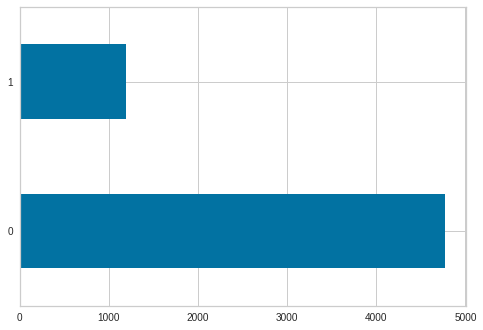

In [7]:
print(df_2['BAD'].value_counts())
df_2['BAD'].value_counts().plot.barh()

In [8]:
df_2.BAD.value_counts()/len(df_2) * 100 
# 1 = client defaulted on loan; 0 = loan repaid
# zeroes are about 80% and ones are about 20%
# The target class is an unbalanced 

0    80.050336
1    19.949664
Name: BAD, dtype: float64

## 4.2 Features ##

<AxesSubplot:ylabel='Frequency'>

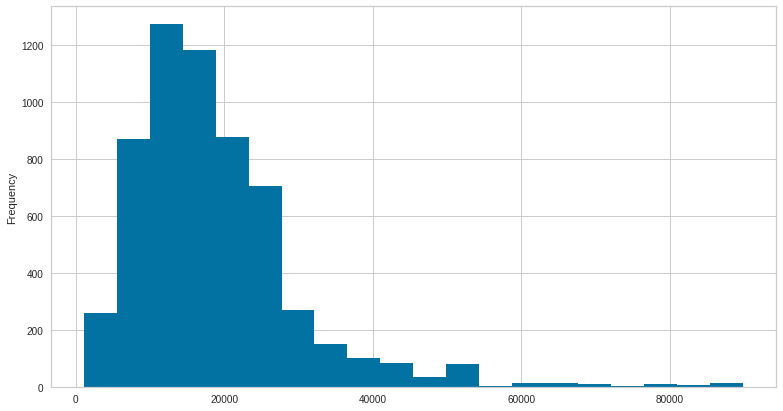

In [8]:
df_2["LOAN"].plot.hist(bins = 20, figsize=(13, 7)) # high destiny 10000 - 30000, we can cap off values >= 60000

<AxesSubplot:ylabel='Frequency'>

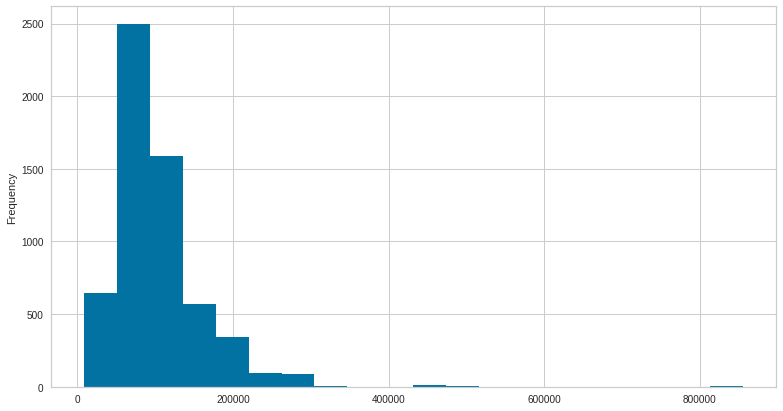

In [9]:
df_2["VALUE"].plot.hist(bins = 20, figsize=(13, 7)) # high destiny 80000 - 100000, we can cap off values >= 40000

<AxesSubplot:ylabel='Frequency'>

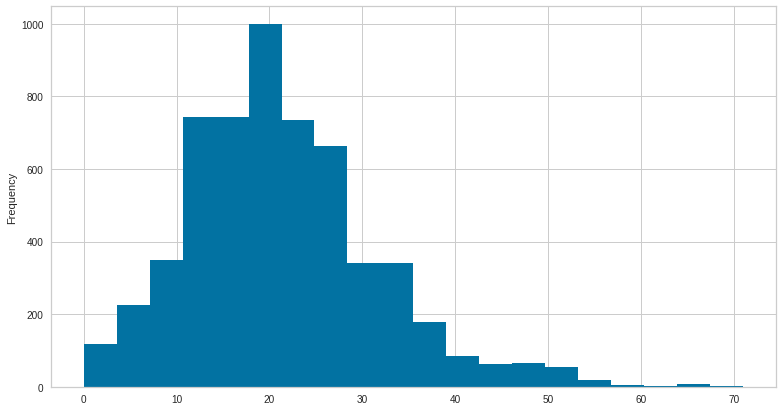

In [10]:
df_2["CLNO"].plot.hist(bins = 20, figsize=(13, 7)) # good distribution no need to modify

<AxesSubplot:ylabel='Frequency'>

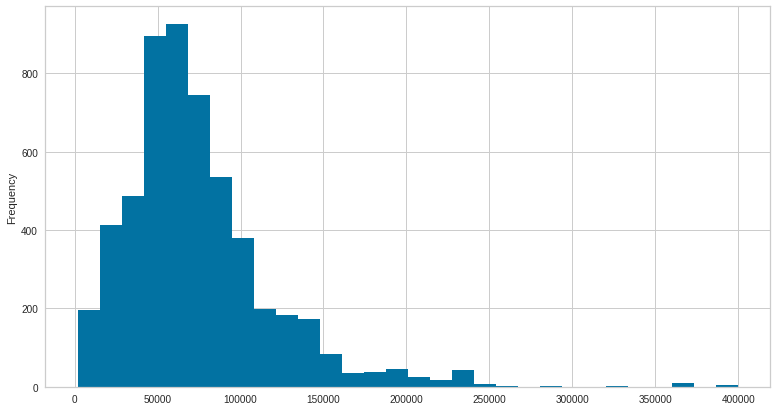

In [11]:
df_2["MORTDUE"].plot.hist(bins = 30, figsize=(13, 7))# high population around 50000 - 100000, the values > = 300000 can be cap off

<AxesSubplot:ylabel='Frequency'>

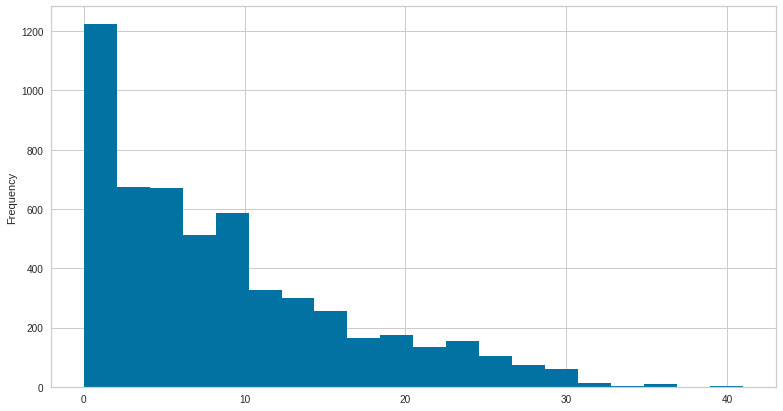

In [12]:
df_2["YOJ"].plot.hist(bins = 20, figsize=(13, 7))# Good idea here is to modify this variable to decrease the skewness

<AxesSubplot:ylabel='Frequency'>

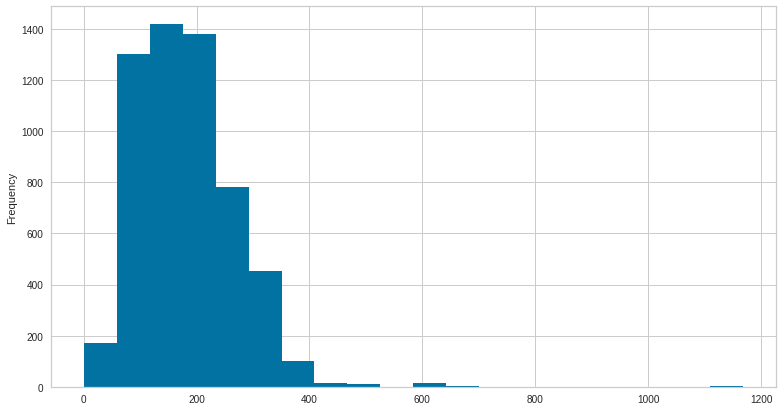

In [14]:
df_2["CLAGE"].plot.hist(bins = 20, figsize=(13, 7)) # Denisty is high around 100  - 300, values >= 600 can cap off

<AxesSubplot:ylabel='Frequency'>

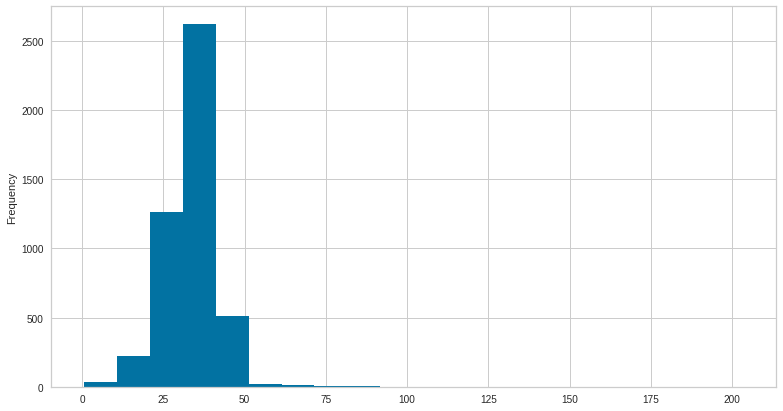

In [13]:
df_2["DEBTINC"].plot.hist(bins = 20, figsize=(13, 7)) # Denisty is high around 25  - 50, values >= 100 can cap off

JOB and REASON must be modified (for logistic regression)
For imputing the missing values in case of nominal features, replacing them with majority class (first replacing values), in case of other numerical inputs, we can replace them by median

In [14]:
print(df_2["JOB"].value_counts())

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64


In [15]:
df_2["JOB"].replace(['Other', 'ProfExe','Office','Mgr', 'Self', 'Sales' ], [0, 1, 2, 3, 4, 5], inplace=True)#replacing values

In [16]:
print(df_2["REASON"].value_counts())

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64


In [17]:
df_2["REASON"].replace(['DebtCon', 'HomeImp'], [0, 1], inplace=True) #replacing values

In [18]:
df_2["DELINQ"].value_counts() #binary variable would be  useful

0.0     4179
1.0      654
2.0      250
3.0      129
4.0       78
5.0       38
6.0       27
7.0       13
8.0        5
10.0       2
11.0       2
15.0       1
12.0       1
13.0       1
Name: DELINQ, dtype: int64

In [19]:
df_2["DEROG"].value_counts() # derogatory incidents were reported only in a few cases, we can create binary variable

0.0     4527
1.0      435
2.0      160
3.0       58
4.0       23
5.0       15
6.0       15
7.0        8
8.0        6
9.0        3
10.0       2
Name: DEROG, dtype: int64

In [20]:
df_2["NINQ"].value_counts() #distributed mostly among first 5  values

0.0     2531
1.0     1339
2.0      780
3.0      392
4.0      156
5.0       75
6.0       56
7.0       44
10.0      28
8.0       22
9.0       11
11.0      10
12.0       2
13.0       2
14.0       1
17.0       1
Name: NINQ, dtype: int64

Distributions are fine, YOJ  is higly skewed

## 4.2.1 Imputing ##

In [21]:
df_2.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

In [22]:
df_2["REASON"].fillna(value = 0, inplace = True) # replacement using majority class in case of REASON variable is 0

In [23]:
df_2["JOB"].fillna(value = 0, inplace = True) # replacement using majority class

In [24]:
df_2["DEROG"].fillna(value = 0, inplace = True)

In [25]:
df_2["DELINQ"].fillna(value = 0, inplace = True)

In [26]:
df_2.fillna(value = df_2.median(numeric_only=True), inplace = True)

In [27]:
df_2.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

# 5. Data Preparation #

## 5.1 Feature transformation ##

As we mentioned in section 4.2 Features we need to transform some variables to improve predictability

In [28]:
df_2.loc[df_2["CLAGE"]>=600, "CLAGE"] = 600
df_2.loc[df_2["VALUE"]>=40000, "VALUE"] = 40000
df_2.loc[df_2["MORTDUE"]>=300000, "MORTDUE"] = 300000
df_2.loc[df_2["DEBTINC"]>=100, "DEBTINC"] = 100

decrease the skewness of YOJ

In [29]:
df_2["YOJ"] = df_2["YOJ"].apply(lambda x: np.log(x+1))

<AxesSubplot:ylabel='Frequency'>

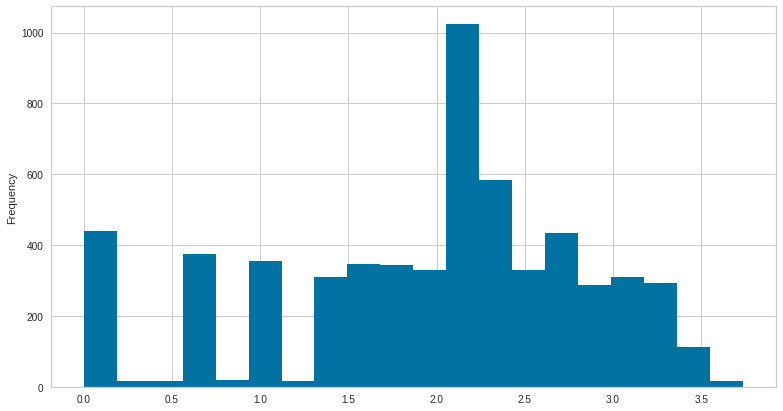

In [30]:
df_2["YOJ"].plot.hist(bins = 20, figsize=(13, 7))

In [31]:
df_2["B_DEROG"] = (df_2["DEROG"]>=1)*1
df_2["B_DELINQ"] = (df_2["DELINQ"]>=1)*1

 ## 5.2 Feature Selection ##

Find features with correlation > 0.75 and delete them 

In [32]:
cor = df_2.corr()

In [33]:
all_features = list(cor.columns)
features_to_del = []
for i in cor.columns:
    if i == 'BAD':
        continue
    for j in cor.index:
        if all_features.index(j) >= all_features.index(i) or j == 'BAD':
            continue
        else:
            if abs(cor.loc[i,j]) > 0.75:
                if abs(cor.loc['BAD', i]) > abs(cor.loc['BAD', j]):
                    features_to_del.append(j)
                else:
                    features_to_del.append(i)

In [34]:
features_to_del = set(features_to_del)

In [35]:
for i in features_to_del:
    del df_2[i]
df_2.shape

(5960, 14)

we can't find features with correlation above 0.75 and will contunue with Performance with Full Set of Features

## 5.2.1 Performance with Full Set of Features ##

Split the dataset columns into X and y(target) then we normalize each descriptive feature in X to be between 0 and 1

In [36]:
X = df_2.drop('BAD', axis = 1)
y = df_2['BAD']

In [37]:
X = preprocessing.MinMaxScaler().fit_transform(X)

In [38]:
rfc = RandomForestClassifier(n_estimators=20, random_state=22) #As wrapper, we use the RandomForestClassifier.

In [39]:
cv_method = RepeatedStratifiedKFold(n_splits=5, #For assessment, we shall use stratified 5-fold cross-validation with 3 repetitions.
                                     n_repeats=3,
                                     random_state=22)

In [40]:
scoring_metric = 'roc_auc'  

In [41]:
cv_results_full = cross_val_score(estimator=rfc,
                             X=X,
                             y=y, 
                             cv=cv_method, 
                             scoring=scoring_metric)

In [42]:
cv_results_full.mean().round(3) #compute the average cross-validation performance as the mean of the cv_results_full array.

0.952

## 5.3. Balanced and split data ##

In [43]:
ros = RandomOverSampler() # we balanced dataset
X_ros, y_ros = ros.fit_resample(X, y)
print(Counter(y_ros))

Counter({1: 4771, 0: 4771})


Now we are ready to split data

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size = 0.2, shuffle = True, random_state = 22, stratify = y_ros)

In [45]:
print(X_train.shape, X_test.shape)

(7633, 13) (1909, 13)


In [46]:
print(y_train.shape, y_test.shape)

(7633,) (1909,)


Let's check how similar are X_test and X_ros

In [47]:
test_mean = np.mean(X_test, axis = 0)
pred_mean = np.mean(X_ros, axis = 0)
print(len(test_mean), len(pred_mean))

13 13


In [48]:
ttest_ind(test_mean, pred_mean)

Ttest_indResult(statistic=-0.0008421777594739507, pvalue=0.9993350007099155)

## 5.4 Recursive Feature Elimination with RFECV

In [49]:
rfecv = RFECV(estimator= rfc, step = 1, cv = 3, scoring="roc_auc") 
rfecv = rfecv.fit(X_train, y_train)

print("The optimal number of features:", rfecv.n_features_)
#print("Best features:", X_train.columns[rfecv.support_].values)

for i in range(X_train.shape[1]):
    
    print(f'Column: {i}, Selected {rfecv.support_[i]}, Rank: {rfecv.ranking_[i]}') 

The optimal number of features: 13
Column: 0, Selected True, Rank: 1
Column: 1, Selected True, Rank: 1
Column: 2, Selected True, Rank: 1
Column: 3, Selected True, Rank: 1
Column: 4, Selected True, Rank: 1
Column: 5, Selected True, Rank: 1
Column: 6, Selected True, Rank: 1
Column: 7, Selected True, Rank: 1
Column: 8, Selected True, Rank: 1
Column: 9, Selected True, Rank: 1
Column: 10, Selected True, Rank: 1
Column: 11, Selected True, Rank: 1
Column: 12, Selected True, Rank: 1


now we ready to select our features

In [50]:
sel_ = RFECV(
    rfc,
    min_features_to_select=13,
    step=2,
)

sel_.fit(X_train, y_train)

X_train_selected = sel_.transform(X_train)
X_test_selected = sel_.transform(X_test)

## 5.5. Clusters and searching for outliers with DBSCAN ##

Although we have looked at all the variables and tried to remove the outlying values. Now we will try using elbow method for KMeans clustering to find out how many clusters form in our dataset and with DBSCAN to find out if there are any outliers left.

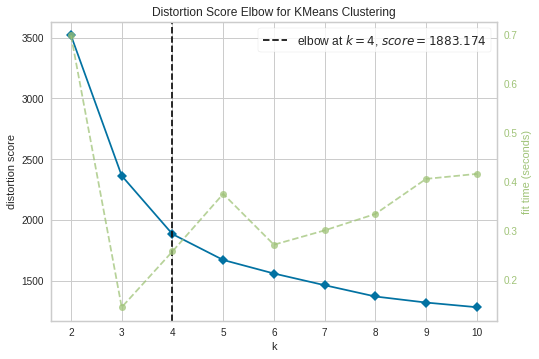

In [51]:
model = KMeans(random_state = 1)
visualizer = KElbowVisualizer(model)

visualizer.fit(X_train_selected) 
visualizer.show()
plt.show()

In [52]:
scala = StandardScaler()
df_2_scaled = scala.fit_transform(X_train_selected)

In [53]:
outlier_percent = []

for eps in np.linspace(0.001, 5, 100):
    
    dbscan = DBSCAN(eps=eps, min_samples = 26) # a good 'min_samples' number is two times the number of features
    dbscan.fit(df_2_scaled)
    perc_outliers = 100*np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    outlier_percent.append(perc_outliers)

Text(0, 0.5, 'Percentage of Points Classified as Outliers')

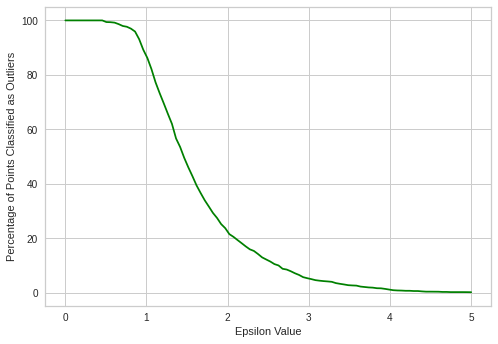

In [54]:
sns.lineplot(x=np.linspace(0.001, 5, 100), y=outlier_percent, color='green')
plt.xlabel('Epsilon Value')
plt.ylabel('Percentage of Points Classified as Outliers')

In [55]:
dend = linkage(df_2_scaled, method = "ward")
dend

array([[3.00000000e+00, 4.21100000e+03, 0.00000000e+00, 2.00000000e+00],
       [5.00000000e+00, 8.46000000e+02, 0.00000000e+00, 2.00000000e+00],
       [6.00000000e+00, 8.55000000e+02, 0.00000000e+00, 2.00000000e+00],
       ...,
       [1.52570000e+04, 1.52600000e+04, 9.74030905e+01, 5.06200000e+03],
       [1.52480000e+04, 1.52620000e+04, 1.08471018e+02, 5.30500000e+03],
       [1.52610000e+04, 1.52630000e+04, 1.45965259e+02, 7.63300000e+03]])

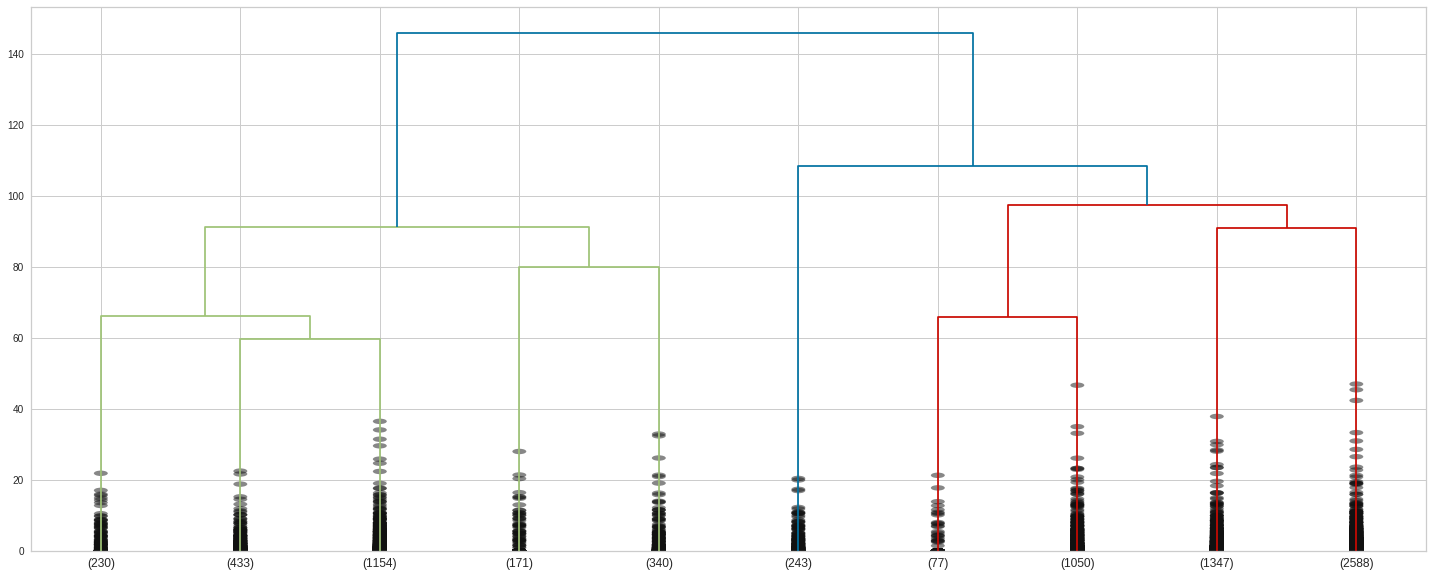

In [56]:
plt.figure(figsize = (25,10))
dendr = dendrogram(dend, truncate_mode="lastp", p = 10, show_leaf_counts = True, show_contracted = True)

In [57]:
df_2_for_clust = preprocessing.normalize(X_train_selected)
df_2_for_clust

array([[0.04235595, 0.16557654, 0.78358502, ..., 0.22072818, 0.25410499,
        0.        ],
       [0.20723998, 0.09969502, 0.67409927, ..., 0.19938148, 0.22528278,
        0.        ],
       [0.15283861, 0.28012545, 0.77114024, ..., 0.15205582, 0.23278088,
        0.        ],
       ...,
       [0.05225889, 0.13062095, 0.5214145 , ..., 0.19094052, 0.17975547,
        0.5214145 ],
       [0.04632134, 0.07309013, 0.64270866, ..., 0.2082014 , 0.22157112,
        0.        ],
       [0.16027738, 0.21498524, 0.74516393, ..., 0.157429  , 0.29508611,
        0.        ]])

In [58]:
clusters = DBSCAN(eps = 2.5, min_samples = 26).fit_predict(df_2_for_clust) # I checked with eps 2, 3 the same result, zero outliers

In [59]:
list(clusters).count(-1) # show us how many outliers in the dataset

0

# 6. Algorithm Evaluation #

## 6.1 CatBoost ##

I am planning to start with CatBoost. It's an improved implementation of Gradient Boosting Decision Trees (GBDT). CatBoost solves the problem of Gradient Bias and Prediction Shift, this allows you to reduce the likelihood of overfitting and improve the accuracy of the algorithm.

In [61]:
CBC = CatBoostClassifier()

parameters = {'depth'         : [5,6,7,8,9,10],
                'learning_rate' : [0.01,0.02,0.03,0.04],
                'iterations'    : [50, 150, 300]
                 }

Rand_CBC = RandomizedSearchCV(estimator=CBC, param_distributions = parameters, cv = 3, n_jobs=-1, scoring = 'f1', random_state = 22)
#cv : In this we have to pass a interger value, as it signifies the number of splits that is needed for cross validation. By default is set as five.
#n_jobs : This signifies the number of jobs to be run in parallel, -1 signifies to use all processor.
Rand_CBC.fit(X_train_selected, y_train)

0:	learn: 0.6759080	total: 156ms	remaining: 7.64s
1:	learn: 0.6602364	total: 163ms	remaining: 3.9s
2:	learn: 0.6449594	total: 174ms	remaining: 2.72s
3:	learn: 0.6309724	total: 187ms	remaining: 2.15s
4:	learn: 0.6182785	total: 193ms	remaining: 1.73s
5:	learn: 0.6063000	total: 208ms	remaining: 1.52s
6:	learn: 0.5945681	total: 219ms	remaining: 1.34s
7:	learn: 0.5830495	total: 229ms	remaining: 1.2s
8:	learn: 0.5727360	total: 240ms	remaining: 1.09s
9:	learn: 0.5631419	total: 251ms	remaining: 1s
10:	learn: 0.5536365	total: 265ms	remaining: 939ms
11:	learn: 0.5447722	total: 275ms	remaining: 871ms
12:	learn: 0.5368199	total: 287ms	remaining: 818ms
13:	learn: 0.5296386	total: 299ms	remaining: 769ms
14:	learn: 0.5220609	total: 309ms	remaining: 721ms
15:	learn: 0.5171095	total: 318ms	remaining: 677ms
16:	learn: 0.5106756	total: 327ms	remaining: 634ms
17:	learn: 0.5042495	total: 343ms	remaining: 610ms
18:	learn: 0.4983639	total: 354ms	remaining: 578ms
19:	learn: 0.4922787	total: 364ms	remaining: 5

11:	learn: 0.5733703	total: 567ms	remaining: 6.52s
12:	learn: 0.5660473	total: 598ms	remaining: 6.3s
13:	learn: 0.5585525	total: 627ms	remaining: 6.09s
14:	learn: 0.5517798	total: 657ms	remaining: 5.91s
15:	learn: 0.5452783	total: 695ms	remaining: 5.82s
16:	learn: 0.5388892	total: 747ms	remaining: 5.84s
17:	learn: 0.5322532	total: 828ms	remaining: 6.07s
18:	learn: 0.5261165	total: 865ms	remaining: 5.96s
19:	learn: 0.5203617	total: 914ms	remaining: 5.94s
20:	learn: 0.5138751	total: 986ms	remaining: 6.05s
21:	learn: 0.5082570	total: 1.06s	remaining: 6.19s
22:	learn: 0.5030457	total: 1.13s	remaining: 6.23s
23:	learn: 0.4981851	total: 1.21s	remaining: 6.34s
24:	learn: 0.4933085	total: 1.28s	remaining: 6.38s
25:	learn: 0.4884540	total: 1.33s	remaining: 6.37s
26:	learn: 0.4840247	total: 1.39s	remaining: 6.34s
27:	learn: 0.4787831	total: 1.45s	remaining: 6.32s
28:	learn: 0.4741912	total: 1.51s	remaining: 6.31s
29:	learn: 0.4699149	total: 1.57s	remaining: 6.29s
30:	learn: 0.4660157	total: 1.64

21:	learn: 0.4591195	total: 505ms	remaining: 6.38s
22:	learn: 0.4554336	total: 531ms	remaining: 6.39s
23:	learn: 0.4518962	total: 558ms	remaining: 6.41s
24:	learn: 0.4472454	total: 585ms	remaining: 6.43s
25:	learn: 0.4438663	total: 608ms	remaining: 6.41s
26:	learn: 0.4408974	total: 634ms	remaining: 6.41s
27:	learn: 0.4368314	total: 657ms	remaining: 6.38s
28:	learn: 0.4333894	total: 678ms	remaining: 6.34s
29:	learn: 0.4296934	total: 700ms	remaining: 6.3s
30:	learn: 0.4259584	total: 726ms	remaining: 6.3s
31:	learn: 0.4228349	total: 748ms	remaining: 6.26s
32:	learn: 0.4199718	total: 773ms	remaining: 6.25s
33:	learn: 0.4169007	total: 794ms	remaining: 6.21s
34:	learn: 0.4140577	total: 834ms	remaining: 6.31s
35:	learn: 0.4112558	total: 859ms	remaining: 6.3s
36:	learn: 0.4085463	total: 884ms	remaining: 6.28s
37:	learn: 0.4064096	total: 902ms	remaining: 6.22s
38:	learn: 0.4043601	total: 913ms	remaining: 6.11s
39:	learn: 0.4020295	total: 930ms	remaining: 6.05s
40:	learn: 0.3996079	total: 937ms	

21:	learn: 0.5103068	total: 1.18s	remaining: 6.84s
22:	learn: 0.5046680	total: 1.25s	remaining: 6.88s
23:	learn: 0.4995258	total: 1.3s	remaining: 6.83s
24:	learn: 0.4945297	total: 1.36s	remaining: 6.8s
25:	learn: 0.4902099	total: 1.45s	remaining: 6.91s
26:	learn: 0.4859194	total: 1.51s	remaining: 6.88s
27:	learn: 0.4810876	total: 1.59s	remaining: 6.93s
28:	learn: 0.4769073	total: 1.65s	remaining: 6.87s
29:	learn: 0.4727194	total: 1.71s	remaining: 6.84s
30:	learn: 0.4690447	total: 1.77s	remaining: 6.79s
31:	learn: 0.4651112	total: 1.83s	remaining: 6.75s
32:	learn: 0.4618420	total: 1.92s	remaining: 6.81s
33:	learn: 0.4581448	total: 2s	remaining: 6.82s
34:	learn: 0.4546089	total: 2.05s	remaining: 6.74s
35:	learn: 0.4510028	total: 2.11s	remaining: 6.69s
36:	learn: 0.4484129	total: 2.13s	remaining: 6.52s
37:	learn: 0.4450413	total: 2.21s	remaining: 6.5s
38:	learn: 0.4416905	total: 2.28s	remaining: 6.49s
39:	learn: 0.4386202	total: 2.36s	remaining: 6.5s
40:	learn: 0.4355376	total: 2.45s	rema

31:	learn: 0.4290777	total: 594ms	remaining: 4.97s
32:	learn: 0.4258948	total: 603ms	remaining: 4.87s
33:	learn: 0.4237352	total: 620ms	remaining: 4.85s
34:	learn: 0.4210364	total: 634ms	remaining: 4.8s
35:	learn: 0.4183914	total: 651ms	remaining: 4.78s
36:	learn: 0.4157416	total: 664ms	remaining: 4.72s
37:	learn: 0.4134933	total: 679ms	remaining: 4.68s
38:	learn: 0.4111458	total: 696ms	remaining: 4.66s
39:	learn: 0.4094798	total: 712ms	remaining: 4.63s
40:	learn: 0.4069659	total: 727ms	remaining: 4.59s
41:	learn: 0.4049081	total: 743ms	remaining: 4.56s
42:	learn: 0.4030365	total: 757ms	remaining: 4.52s
43:	learn: 0.4016160	total: 773ms	remaining: 4.5s
44:	learn: 0.3993325	total: 785ms	remaining: 4.45s
45:	learn: 0.3974730	total: 803ms	remaining: 4.43s
46:	learn: 0.3957334	total: 815ms	remaining: 4.39s
47:	learn: 0.3941476	total: 827ms	remaining: 4.34s
48:	learn: 0.3919305	total: 853ms	remaining: 4.37s
49:	learn: 0.3903285	total: 864ms	remaining: 4.32s
50:	learn: 0.3884822	total: 884ms

190:	learn: 0.2748966	total: 2.55s	remaining: 1.46s
191:	learn: 0.2741237	total: 2.56s	remaining: 1.44s
192:	learn: 0.2737459	total: 2.58s	remaining: 1.43s
193:	learn: 0.2732118	total: 2.59s	remaining: 1.41s
194:	learn: 0.2729387	total: 2.6s	remaining: 1.4s
195:	learn: 0.2726165	total: 2.61s	remaining: 1.39s
196:	learn: 0.2722912	total: 2.62s	remaining: 1.37s
197:	learn: 0.2717496	total: 2.63s	remaining: 1.36s
198:	learn: 0.2714356	total: 2.65s	remaining: 1.34s
199:	learn: 0.2710842	total: 2.66s	remaining: 1.33s
200:	learn: 0.2705748	total: 2.67s	remaining: 1.31s
201:	learn: 0.2702299	total: 2.68s	remaining: 1.3s
202:	learn: 0.2694185	total: 2.69s	remaining: 1.29s
203:	learn: 0.2692512	total: 2.71s	remaining: 1.27s
204:	learn: 0.2688503	total: 2.72s	remaining: 1.26s
205:	learn: 0.2683688	total: 2.73s	remaining: 1.24s
206:	learn: 0.2681508	total: 2.74s	remaining: 1.23s
207:	learn: 0.2675404	total: 2.76s	remaining: 1.22s
208:	learn: 0.2669553	total: 2.76s	remaining: 1.2s
209:	learn: 0.26

48:	learn: 0.4004701	total: 556ms	remaining: 1.15s
49:	learn: 0.3989802	total: 574ms	remaining: 1.15s
50:	learn: 0.3974483	total: 583ms	remaining: 1.13s
51:	learn: 0.3959879	total: 590ms	remaining: 1.11s
52:	learn: 0.3947406	total: 598ms	remaining: 1.09s
53:	learn: 0.3934791	total: 609ms	remaining: 1.08s
54:	learn: 0.3919636	total: 620ms	remaining: 1.07s
55:	learn: 0.3902629	total: 632ms	remaining: 1.06s
56:	learn: 0.3886169	total: 643ms	remaining: 1.05s
57:	learn: 0.3871163	total: 654ms	remaining: 1.04s
58:	learn: 0.3861931	total: 664ms	remaining: 1.02s
59:	learn: 0.3844938	total: 677ms	remaining: 1.01s
60:	learn: 0.3830320	total: 688ms	remaining: 1s
61:	learn: 0.3814419	total: 700ms	remaining: 994ms
62:	learn: 0.3803497	total: 713ms	remaining: 985ms
63:	learn: 0.3789884	total: 724ms	remaining: 973ms
64:	learn: 0.3776644	total: 735ms	remaining: 961ms
65:	learn: 0.3765620	total: 747ms	remaining: 951ms
66:	learn: 0.3749656	total: 762ms	remaining: 944ms
67:	learn: 0.3739030	total: 771ms	

58:	learn: 0.3894569	total: 761ms	remaining: 3.11s
59:	learn: 0.3881537	total: 778ms	remaining: 3.11s
60:	learn: 0.3869467	total: 793ms	remaining: 3.11s
61:	learn: 0.3861929	total: 799ms	remaining: 3.07s
62:	learn: 0.3849203	total: 810ms	remaining: 3.05s
63:	learn: 0.3833089	total: 823ms	remaining: 3.04s
64:	learn: 0.3820962	total: 834ms	remaining: 3.02s
65:	learn: 0.3810706	total: 846ms	remaining: 3s
66:	learn: 0.3798472	total: 855ms	remaining: 2.97s
67:	learn: 0.3786833	total: 869ms	remaining: 2.96s
68:	learn: 0.3773637	total: 875ms	remaining: 2.93s
69:	learn: 0.3763900	total: 894ms	remaining: 2.94s
70:	learn: 0.3757700	total: 912ms	remaining: 2.94s
71:	learn: 0.3749040	total: 924ms	remaining: 2.93s
72:	learn: 0.3739933	total: 942ms	remaining: 2.93s
73:	learn: 0.3731554	total: 972ms	remaining: 2.97s
74:	learn: 0.3718208	total: 987ms	remaining: 2.96s
75:	learn: 0.3708109	total: 1s	remaining: 2.95s
76:	learn: 0.3699468	total: 1.01s	remaining: 2.93s
77:	learn: 0.3689217	total: 1.02s	rem

217:	learn: 0.2869940	total: 2.61s	remaining: 982ms
218:	learn: 0.2863784	total: 2.62s	remaining: 968ms
219:	learn: 0.2860306	total: 2.63s	remaining: 955ms
220:	learn: 0.2856703	total: 2.64s	remaining: 943ms
221:	learn: 0.2852942	total: 2.65s	remaining: 929ms
222:	learn: 0.2849931	total: 2.65s	remaining: 917ms
223:	learn: 0.2846554	total: 2.66s	remaining: 904ms
224:	learn: 0.2842294	total: 2.67s	remaining: 891ms
225:	learn: 0.2838996	total: 2.68s	remaining: 878ms
226:	learn: 0.2835590	total: 2.69s	remaining: 865ms
227:	learn: 0.2830327	total: 2.7s	remaining: 853ms
228:	learn: 0.2824409	total: 2.71s	remaining: 839ms
229:	learn: 0.2820876	total: 2.71s	remaining: 826ms
230:	learn: 0.2817596	total: 2.72s	remaining: 814ms
231:	learn: 0.2813530	total: 2.73s	remaining: 802ms
232:	learn: 0.2808583	total: 2.74s	remaining: 788ms
233:	learn: 0.2806209	total: 2.75s	remaining: 776ms
234:	learn: 0.2799154	total: 2.76s	remaining: 763ms
235:	learn: 0.2795376	total: 2.77s	remaining: 750ms
236:	learn: 0

233:	learn: 0.2913594	total: 2.2s	remaining: 620ms
234:	learn: 0.2910375	total: 2.2s	remaining: 609ms
235:	learn: 0.2906862	total: 2.21s	remaining: 600ms
236:	learn: 0.2903580	total: 2.22s	remaining: 591ms
237:	learn: 0.2896994	total: 2.23s	remaining: 581ms
238:	learn: 0.2893948	total: 2.24s	remaining: 571ms
239:	learn: 0.2891441	total: 2.25s	remaining: 562ms
240:	learn: 0.2887191	total: 2.25s	remaining: 552ms
241:	learn: 0.2885674	total: 2.27s	remaining: 544ms
242:	learn: 0.2883167	total: 2.28s	remaining: 534ms
243:	learn: 0.2879323	total: 2.28s	remaining: 524ms
244:	learn: 0.2877252	total: 2.29s	remaining: 514ms
245:	learn: 0.2872485	total: 2.3s	remaining: 504ms
246:	learn: 0.2867663	total: 2.31s	remaining: 495ms
247:	learn: 0.2861406	total: 2.31s	remaining: 485ms
248:	learn: 0.2859091	total: 2.32s	remaining: 476ms
249:	learn: 0.2856909	total: 2.33s	remaining: 465ms
250:	learn: 0.2853011	total: 2.34s	remaining: 456ms
251:	learn: 0.2847398	total: 2.35s	remaining: 447ms
252:	learn: 0.2

42:	learn: 0.4789652	total: 2.15s	remaining: 350ms
43:	learn: 0.4761912	total: 2.21s	remaining: 302ms
44:	learn: 0.4732692	total: 2.29s	remaining: 254ms
45:	learn: 0.4708435	total: 2.37s	remaining: 206ms
46:	learn: 0.4683250	total: 2.47s	remaining: 158ms
47:	learn: 0.4656152	total: 2.54s	remaining: 106ms
48:	learn: 0.4633887	total: 2.61s	remaining: 53.2ms
49:	learn: 0.4614161	total: 2.67s	remaining: 0us
0:	learn: 0.6887721	total: 11.2ms	remaining: 1.67s
1:	learn: 0.6845692	total: 20.8ms	remaining: 1.54s
2:	learn: 0.6805055	total: 35.2ms	remaining: 1.73s
3:	learn: 0.6763417	total: 45ms	remaining: 1.64s
4:	learn: 0.6722606	total: 57.6ms	remaining: 1.67s
5:	learn: 0.6683318	total: 66.6ms	remaining: 1.6s
6:	learn: 0.6644376	total: 78ms	remaining: 1.59s
7:	learn: 0.6603619	total: 92.7ms	remaining: 1.64s
8:	learn: 0.6566402	total: 104ms	remaining: 1.62s
9:	learn: 0.6528858	total: 113ms	remaining: 1.59s
10:	learn: 0.6489865	total: 131ms	remaining: 1.65s
11:	learn: 0.6452192	total: 148ms	remai

43:	learn: 0.5547790	total: 459ms	remaining: 1.1s
44:	learn: 0.5526966	total: 468ms	remaining: 1.09s
45:	learn: 0.5505038	total: 473ms	remaining: 1.07s
46:	learn: 0.5487023	total: 476ms	remaining: 1.04s
47:	learn: 0.5467708	total: 481ms	remaining: 1.02s
48:	learn: 0.5447910	total: 484ms	remaining: 998ms
49:	learn: 0.5427710	total: 488ms	remaining: 975ms
50:	learn: 0.5407462	total: 492ms	remaining: 954ms
51:	learn: 0.5387709	total: 495ms	remaining: 933ms
52:	learn: 0.5367253	total: 500ms	remaining: 914ms
53:	learn: 0.5348064	total: 503ms	remaining: 895ms
54:	learn: 0.5331234	total: 507ms	remaining: 876ms
55:	learn: 0.5313633	total: 511ms	remaining: 858ms
56:	learn: 0.5296035	total: 514ms	remaining: 839ms
57:	learn: 0.5275834	total: 519ms	remaining: 824ms
58:	learn: 0.5259871	total: 523ms	remaining: 807ms
59:	learn: 0.5241211	total: 527ms	remaining: 791ms
60:	learn: 0.5225590	total: 531ms	remaining: 774ms
61:	learn: 0.5209274	total: 534ms	remaining: 758ms
62:	learn: 0.5190578	total: 539m

169:	learn: 0.1427386	total: 7.59s	remaining: 5.81s
170:	learn: 0.1421547	total: 7.64s	remaining: 5.76s
171:	learn: 0.1413023	total: 7.68s	remaining: 5.72s
172:	learn: 0.1410223	total: 7.73s	remaining: 5.67s
173:	learn: 0.1406940	total: 7.77s	remaining: 5.63s
174:	learn: 0.1402117	total: 7.83s	remaining: 5.59s
175:	learn: 0.1396285	total: 7.9s	remaining: 5.57s
176:	learn: 0.1384612	total: 7.94s	remaining: 5.52s
177:	learn: 0.1376848	total: 7.98s	remaining: 5.47s
178:	learn: 0.1368516	total: 8.02s	remaining: 5.42s
179:	learn: 0.1359784	total: 8.05s	remaining: 5.37s
180:	learn: 0.1349789	total: 8.1s	remaining: 5.32s
181:	learn: 0.1339954	total: 8.14s	remaining: 5.28s
182:	learn: 0.1331713	total: 8.18s	remaining: 5.23s
183:	learn: 0.1327127	total: 8.21s	remaining: 5.18s
184:	learn: 0.1321570	total: 8.26s	remaining: 5.13s
185:	learn: 0.1312814	total: 8.3s	remaining: 5.08s
186:	learn: 0.1306132	total: 8.34s	remaining: 5.04s
187:	learn: 0.1300828	total: 8.38s	remaining: 4.99s
188:	learn: 0.1

70:	learn: 0.2550386	total: 2.57s	remaining: 8.28s
71:	learn: 0.2538405	total: 2.59s	remaining: 8.19s
72:	learn: 0.2522787	total: 2.6s	remaining: 8.1s
73:	learn: 0.2510181	total: 2.62s	remaining: 8.01s
74:	learn: 0.2496833	total: 2.64s	remaining: 7.92s
75:	learn: 0.2471225	total: 2.66s	remaining: 7.84s
76:	learn: 0.2451760	total: 2.69s	remaining: 7.78s
77:	learn: 0.2431609	total: 2.71s	remaining: 7.72s
78:	learn: 0.2407331	total: 2.76s	remaining: 7.73s
79:	learn: 0.2383679	total: 2.81s	remaining: 7.71s
80:	learn: 0.2362270	total: 2.85s	remaining: 7.7s
81:	learn: 0.2349585	total: 2.89s	remaining: 7.69s
82:	learn: 0.2327979	total: 2.94s	remaining: 7.69s
83:	learn: 0.2304143	total: 3s	remaining: 7.72s
84:	learn: 0.2293851	total: 3.06s	remaining: 7.75s
85:	learn: 0.2277461	total: 3.12s	remaining: 7.75s
86:	learn: 0.2259333	total: 3.16s	remaining: 7.74s
87:	learn: 0.2250833	total: 3.21s	remaining: 7.72s
88:	learn: 0.2239527	total: 3.25s	remaining: 7.7s
89:	learn: 0.2225547	total: 3.3s	remai

10:	learn: 0.4798555	total: 286ms	remaining: 7.5s
11:	learn: 0.4663502	total: 332ms	remaining: 7.96s
12:	learn: 0.4578452	total: 355ms	remaining: 7.85s
13:	learn: 0.4494685	total: 375ms	remaining: 7.67s
14:	learn: 0.4397712	total: 395ms	remaining: 7.51s
15:	learn: 0.4320108	total: 415ms	remaining: 7.37s
16:	learn: 0.4238619	total: 435ms	remaining: 7.25s
17:	learn: 0.4173852	total: 455ms	remaining: 7.13s
18:	learn: 0.4086631	total: 476ms	remaining: 7.04s
19:	learn: 0.4021855	total: 505ms	remaining: 7.06s
20:	learn: 0.3954352	total: 535ms	remaining: 7.11s
21:	learn: 0.3872234	total: 561ms	remaining: 7.08s
22:	learn: 0.3825641	total: 581ms	remaining: 6.99s
23:	learn: 0.3781558	total: 600ms	remaining: 6.9s
24:	learn: 0.3742158	total: 621ms	remaining: 6.83s
25:	learn: 0.3703659	total: 641ms	remaining: 6.75s
26:	learn: 0.3630948	total: 661ms	remaining: 6.68s
27:	learn: 0.3583599	total: 682ms	remaining: 6.62s
28:	learn: 0.3536275	total: 701ms	remaining: 6.55s
29:	learn: 0.3492426	total: 745ms

176:	learn: 0.1333649	total: 4.43s	remaining: 3.08s
177:	learn: 0.1323615	total: 4.48s	remaining: 3.07s
178:	learn: 0.1320553	total: 4.5s	remaining: 3.04s
179:	learn: 0.1309883	total: 4.53s	remaining: 3.02s
180:	learn: 0.1307880	total: 4.55s	remaining: 2.99s
181:	learn: 0.1303435	total: 4.58s	remaining: 2.97s
182:	learn: 0.1297399	total: 4.6s	remaining: 2.94s
183:	learn: 0.1291823	total: 4.63s	remaining: 2.92s
184:	learn: 0.1286077	total: 4.67s	remaining: 2.9s
185:	learn: 0.1280954	total: 4.71s	remaining: 2.89s
186:	learn: 0.1272671	total: 4.74s	remaining: 2.86s
187:	learn: 0.1268650	total: 4.76s	remaining: 2.84s
188:	learn: 0.1263231	total: 4.79s	remaining: 2.81s
189:	learn: 0.1257109	total: 4.82s	remaining: 2.79s
190:	learn: 0.1251580	total: 4.86s	remaining: 2.77s
191:	learn: 0.1247577	total: 4.89s	remaining: 2.75s
192:	learn: 0.1241288	total: 4.92s	remaining: 2.73s
193:	learn: 0.1236774	total: 4.95s	remaining: 2.7s
194:	learn: 0.1231987	total: 4.97s	remaining: 2.68s
195:	learn: 0.12

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f14e7f2fc40>,
                   n_jobs=-1,
                   param_distributions={'depth': [5, 6, 7, 8, 9, 10],
                                        'iterations': [50, 150, 300],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04]},
                   random_state=22, scoring='f1')

In [62]:
print(" Results from Randomized Search " )
print("\n The best score across ALL searched params:\n",Rand_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Rand_CBC.best_params_)
print(metrics.confusion_matrix(y_test, Rand_CBC.predict(X_test_selected)))

 Results from Randomized Search 

 The best score across ALL searched params:
 0.9554271162942914

 The best parameters across ALL searched params:
 {'learning_rate': 0.04, 'iterations': 300, 'depth': 9}
[[896  58]
 [  2 953]]


In [63]:
print(classification_report(y_test, Rand_CBC.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       954
           1       0.94      1.00      0.97       955

    accuracy                           0.97      1909
   macro avg       0.97      0.97      0.97      1909
weighted avg       0.97      0.97      0.97      1909



## 6.2 Logistic Regression ##

In [64]:
Log_reg_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("Log_reg", LogisticRegression())
])

In [65]:
parameters = {
    'Log_reg__solver' : ['liblinear', 'saga'],
    'Log_reg__C' :[ 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
    'Log_reg__penalty' : ["l1", "l2"]
}

In [66]:
rand_search_Log_reg = RandomizedSearchCV(Log_reg_pipeline , param_distributions = parameters, cv = 3, scoring='f1', n_jobs = -1, random_state = 22)

In [67]:
rand_search_Log_reg.fit(X_train_selected, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('Log_reg',
                                              LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'Log_reg__C': [0.001, 0.01, 0.1, 1, 10,
                                                       100, 1000, 10000],
                                        'Log_reg__penalty': ['l1', 'l2'],
                                        'Log_reg__solver': ['liblinear',
                                                            'saga']},
                   random_state=22, scoring='f1')

In [83]:
# Predict the labels of the test set
y_pred = rand_search_Log_reg.predict(X_test_selected)

# Compute and print metrics
print(f'Accuracy: {rand_search_Log_reg.score(X_test_selected, y_test)}')
print(classification_report(y_test, y_pred))
print(f'Tuned Model Parameters: {rand_search_Log_reg.best_params_}')
print(metrics.confusion_matrix(y_test, rand_search_Log_reg.predict(X_test_selected)))

Accuracy: 0.6966292134831461
              precision    recall  f1-score   support

           0       0.69      0.79      0.74       954
           1       0.75      0.65      0.70       955

    accuracy                           0.72      1909
   macro avg       0.72      0.72      0.72      1909
weighted avg       0.72      0.72      0.72      1909

Tuned Model Parameters: {'Log_reg__solver': 'saga', 'Log_reg__penalty': 'l2', 'Log_reg__C': 1}
[[749 205]
 [335 620]]


## 6.3 Support Vector Classification ##

In [72]:
SVM_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", SVC())
])

In [73]:
parameters = {
    'SVM__C':[0.001, 0.1, 1, 10, 100],
    'SVM__gamma':[0.01, 0.1, 1],
    'SVM__kernel' : ['linear', 'rbf'],
}

In [74]:
rand_search_svc = RandomizedSearchCV(SVM_pipeline, param_distributions = parameters, cv = 3, scoring='f1', n_jobs = -1, random_state = 22)

In [75]:
rand_search_svc.fit(X_train_selected, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('SVM', SVC())]),
                   n_jobs=-1,
                   param_distributions={'SVM__C': [0.001, 0.1, 1, 10, 100],
                                        'SVM__gamma': [0.01, 0.1, 1],
                                        'SVM__kernel': ['linear', 'rbf']},
                   random_state=22, scoring='f1')

In [84]:
# Predict the labels of the test set
y_pred = rand_search_svc.predict(X_test_selected)

# Compute and print metrics
print(f'Accuracy: {rand_search_svc.score(X_test_selected, y_test)}')
print(classification_report(y_test, y_pred))
print(f'Tuned Model Parameters: {rand_search_svc.best_params_}')
print(metrics.confusion_matrix(y_test, rand_search_svc.predict(X_test_selected)))

Accuracy: 0.9860320744956027
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       954
           1       0.97      1.00      0.99       955

    accuracy                           0.99      1909
   macro avg       0.99      0.99      0.99      1909
weighted avg       0.99      0.99      0.99      1909

Tuned Model Parameters: {'SVM__kernel': 'rbf', 'SVM__gamma': 1, 'SVM__C': 10}
[[929  25]
 [  2 953]]


# 7. ROC AUC metric for KNeighborsClassifier, Decision Tree, RandomForestClassifier, GBoost, LinearDiscriminantAnalysis, LGBMClassifier, AdaboostClassifier models with default settings #

In [77]:
roc_auc_scorer = make_scorer(metrics.roc_auc_score, greater_is_better = True, needs_treshold = True)

In [78]:
knc = KNeighborsClassifier() 
knc.fit(X_train, y_train) 

dr = DecisionTreeClassifier()
dr.fit(X_train, y_train)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

nn = MLPClassifier()
nn.fit(X_train, y_train)

GB = Gboost()
GB.fit(X_train, y_train)

lda =LDA()
lda.fit(X_train, y_train)

lgb = lgbm.LGBMClassifier()
lgb.fit(X_train, y_train)

ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

/home/vasil/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


AdaBoostClassifier()

In [79]:
models =   [knc, dr, rf, nn, GB, lda, lgb, ada]
test_list = []
to_train_list = []

for model in models:
    test_list.append(metrics.roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]))
    to_train_list.append(metrics.roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
                        
                        
names =['KNC','DecisionTree', 'RandomForest', 'NN','GB','LDA','LGBM','ADA']
names2 =[i+', '+i for i in names]
print(names2)
names2 =', '.join(names2) 
print(names2)
names2 = names2.split(', ')
print(names2)
    
print()
data = [[test_list[i], to_train_list[i]] for i in range(8)]
print(data)
data = np.array(data).flatten()
print(data)

['KNC, KNC', 'DecisionTree, DecisionTree', 'RandomForest, RandomForest', 'NN, NN', 'GB, GB', 'LDA, LDA', 'LGBM, LGBM', 'ADA, ADA']
KNC, KNC, DecisionTree, DecisionTree, RandomForest, RandomForest, NN, NN, GB, GB, LDA, LDA, LGBM, LGBM, ADA, ADA
['KNC', 'KNC', 'DecisionTree', 'DecisionTree', 'RandomForest', 'RandomForest', 'NN', 'NN', 'GB', 'GB', 'LDA', 'LDA', 'LGBM', 'LGBM', 'ADA', 'ADA']

[[0.9862584653209963, 0.9979114935445478], [0.9475934889745026, 1.0], [0.9987251254019999, 1.0], [0.8657402834030317, 0.8810103646436636], [0.9408508676611017, 0.9546005841680356], [0.7898273458680451, 0.8031305387077232], [0.989130363199315, 0.997841603188648], [0.9244333585783748, 0.9327924245445044]]
[0.98625847 0.99791149 0.94759349 1.         0.99872513 1.
 0.86574028 0.88101036 0.94085087 0.95460058 0.78982735 0.80313054
 0.98913036 0.9978416  0.92443336 0.93279242]


<AxesSubplot:xlabel='Name', ylabel='Data'>

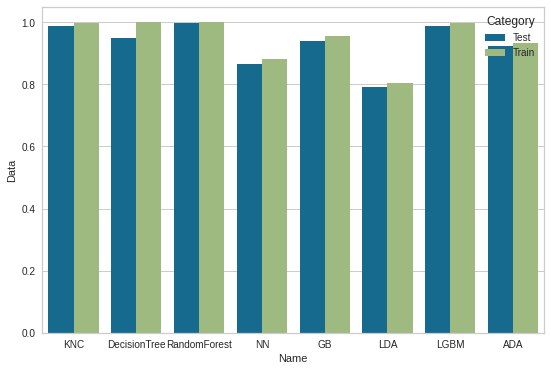

In [80]:
plt.figure(figsize=(9,6))
data1 = {'Name': names2,
         'Data': data,
         'Category': ['Test', 'Train'] * 8}
df2 = pd.DataFrame(data1)
df2
sns.barplot(x='Name',y ='Data', data=df2, hue='Category')

In [81]:
df2

,Name,Data,Category
0,KNC,0.986258,Test
1,KNC,0.997911,Train
2,DecisionTree,0.947593,Test
3,DecisionTree,1.000000,Train
4,RandomForest,0.998725,Test
5,RandomForest,1.000000,Train
6,NN,0.865740,Test
7,NN,0.881010,Train
8,GB,0.940851,Test
9,GB,0.954601,Train


228:	learn: 0.1090688	total: 8.31s	remaining: 2.58s
229:	learn: 0.1081746	total: 8.33s	remaining: 2.54s
230:	learn: 0.1075396	total: 8.35s	remaining: 2.49s
231:	learn: 0.1071106	total: 8.37s	remaining: 2.45s
232:	learn: 0.1062602	total: 8.38s	remaining: 2.41s
233:	learn: 0.1059682	total: 8.4s	remaining: 2.37s
234:	learn: 0.1056942	total: 8.42s	remaining: 2.33s
235:	learn: 0.1054273	total: 8.44s	remaining: 2.29s
236:	learn: 0.1048740	total: 8.46s	remaining: 2.25s
237:	learn: 0.1043577	total: 8.48s	remaining: 2.21s
238:	learn: 0.1034911	total: 8.49s	remaining: 2.17s
239:	learn: 0.1029177	total: 8.52s	remaining: 2.13s
240:	learn: 0.1023165	total: 8.55s	remaining: 2.09s
241:	learn: 0.1018709	total: 8.57s	remaining: 2.05s
242:	learn: 0.1015132	total: 8.6s	remaining: 2.02s
243:	learn: 0.1007776	total: 8.62s	remaining: 1.98s
244:	learn: 0.1003221	total: 8.65s	remaining: 1.94s
245:	learn: 0.1000487	total: 8.67s	remaining: 1.9s
246:	learn: 0.0994544	total: 8.69s	remaining: 1.86s
247:	learn: 0.0

<AxesSubplot:xlabel='Name', ylabel='Data'>

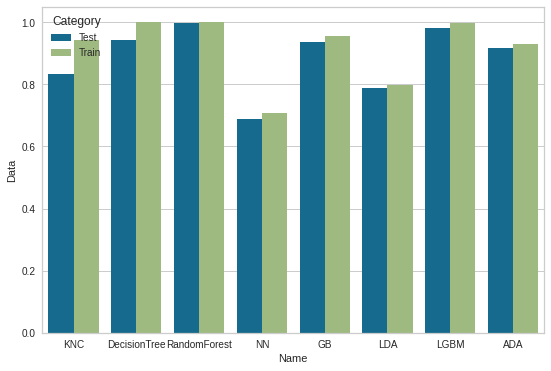

In [70]:
#plt.figure(figsize=(9,6))
#data1 = {'Name': names2,
         #'Data': data,
         #'Category': ['Test', 'Train'] * 8}
#df2 = pd.DataFrame(data1)
#df2
#sns.barplot(x='Name',y ='Data', data=df2, hue='Category')

In [71]:
#df2 results without feature selection and RFECV

,Name,Data,Category
0,KNC,0.833301,Test
1,KNC,0.941764,Train
2,DecisionTree,0.943928,Test
3,DecisionTree,1.000000,Train
4,RandomForest,0.996838,Test
5,RandomForest,1.000000,Train
6,NN,0.688267,Test
7,NN,0.708715,Train
8,GB,0.936139,Test
9,GB,0.954942,Train


# 8. Result Presentation #

 In 6. Algorithm Evaluation the best results were presented by SVC, and the worst by Logistic Regression, bearing in mind that all financial institutions adhere to the rule of using  models which be builted from predictive modeling tools and must be sufficiently interpretable to provide a reason for any adverse actions (rejections). A suitable option is to include other non-interpretable models in the general model. 
 
 We also found that all boosting models without any additional tuning and settings of hyperparameters performed better than Logistic Regression.

The poor performance of the neural network can be due to several factors: 

a) small dataset 

b) default hyperparameters without tuning. 



Random Forest model gives best results with default settings without tuning that's sounds good, because it's easy interpretability. This interpretability is given by that fact that it is straightforward to derive the importance of each variable on the tree decision. in other words, it is easy to compute how much each variable is contributing to the decision.

# 9. Resources #

https://www.kaggle.com/code/aayush7kumar/clustering-using-k-means-hierarchical-and-dbscan/notebook,

https://towardsdatascience.com/machine-learning-target-feature-label-imbalance-problem-and-solutions-98c5ae89ad0#aed2,

https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-2-feature-selection-and-ranking/,

https://machinelearningmastery.com/rfe-feature-selection-in-python/,

https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier,

https://www.projectpro.io/recipes/find-optimal-parameters-for-catboost-using-gridsearchcv-for-classification,

https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html,

https://www.kaggle.com/datasets/ajay1735/hmeq-data,

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html,

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html